Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
import matplotlib.ticker as mtick
import matplotlib
import datetime as dt
import seaborn as sns
from sqlalchemy import *
from scipy.stats import poisson, nbinom
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in both slurm files and concatenate, saving together.
files = ['data/slurm_wrapper_ce6.log', 'data/slurm_wrapper_ce5.log']

for index, value in enumerate(files):
    df = (
        pd.read_csv(value, 
                    sep = ' - ',
                    names = ['DATETIME',
                             'USER',
                             'RETRY',
                             'TIMELAPS',
                             'RETURNCODE',
                             'COMMAND'],
                    engine = 'python'))
    
    df['TIMELAPS'] = (
    df['TIMELAPS'].replace('time ', '', regex = True).astype('float64')
    )
    df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S.%f')
    
    df['DATE'] = df['DATETIME'].apply(lambda x: x.date())
    df['TIME'] = df['DATETIME'].apply(lambda x: x.time())
    
    df['UNRESPONSIVE'] = (
        np.where((df['USER'] == 'user 9204')\
                 & (df['RETURNCODE'] == 'returncode 1')\
                 & (df['COMMAND'].str.contains('sbatch'))\
                 & (df['TIMELAPS'] > 15), 
                 True,
                 False)
    )
    
    df['TESTING'] = (
        np.where((df['USER'] == 'user 9204')\
                 & (df['COMMAND'].str.contains('sbatch')), 
                 True,
                 False)
    )
    df['SERVER'] = ''
    if index == 0:
        df['SERVER'] = 'ce6'
    else:
        df['SERVER'] = 'ce5'
    
    df['JOBID'] = (
        df['COMMAND'].\
        str.extract("\'(\d{2,})\'", expand = True)
    )
    
    df['USERCOUNT'] = np.where(~df['USER'].str.contains('user 9204'), True, False)
    
    if index == 0:
        all_dfs = df
    else:
        all_dfs = pd.concat(objs = [all_dfs, df], axis = 0)
all_dfs = all_dfs.set_index('DATETIME').sort_index(axis = 0, kind = 'mergesort')

In [3]:
# Calculate overall percentage of the time when the scheduler was unresponsive upon a test.
unresponsive_series = all_dfs['UNRESPONSIVE'].loc[all_dfs['UNRESPONSIVE'] == True]
testing_series = all_dfs['TESTING'].loc[all_dfs['TESTING'] == True]
overall_unresponsive_percent = round(len(unresponsive_series)/len(testing_series),9)
print("Scheduler was unresponsive for {:.3%} of all tests.".format(overall_unresponsive_percent))

Scheduler was unresponsive for 5.381% of all tests.


In [4]:
# Group data by sum of unresponsive counts per hour.
relevant_columns = ['TESTING', 'UNRESPONSIVE', 'USERCOUNT']

for index, value in enumerate(relevant_columns):
    df = (
        all_dfs.groupby(pd.Grouper(freq = 'H'))[value].\
        sum().\
        reset_index().\
        rename(columns = {'sum':f'{value}'}))
    if index == 0:
        hour_dfs = df
    else:
        hour_dfs = hour_dfs.merge(df, on = 'DATETIME')

# Determine unresponsive proportion of testing results.
hour_dfs['UNRESPONSIVEPROPORTION'] = (
    hour_dfs['UNRESPONSIVE']/hour_dfs['TESTING']
)

In [5]:
# Resample responsiveness and testing counts and proportion by day, week and month.

responsiveness_by_day = pd.DataFrame()
responsiveness_by_week = pd.DataFrame()
responsiveness_by_month = pd.DataFrame()

list_of_samples = ['D','W','M']

list_of_dfs = [responsiveness_by_day, 
               responsiveness_by_week, 
               responsiveness_by_month]

new_list_of_dfs = []

for index, i in enumerate(list_of_dfs):
    i = (
        pd.DataFrame(hour_dfs.resample(list_of_samples[index], 
                                       on = 'DATETIME')['UNRESPONSIVE',
                                                         'UNRESPONSIVEPROPORTION',
                                                         'TESTING', 
                                                         'USERCOUNT'].sum())
    )
    for j in ['UNRESPONSIVE','UNRESPONSIVEPROPORTION','TESTING','USERCOUNT']:
        i[j + 'MINMAX'] = (
            (i[j] - i[j].min())/(i[j].max() - i[j].min())
    )
    new_list_of_dfs.append(i)

responsiveness_by_day = new_list_of_dfs[0]
responsiveness_by_week = new_list_of_dfs[1]
responsiveness_by_month = new_list_of_dfs[2]

list_of_dfs = [responsiveness_by_day, 
               responsiveness_by_week, 
               responsiveness_by_month]

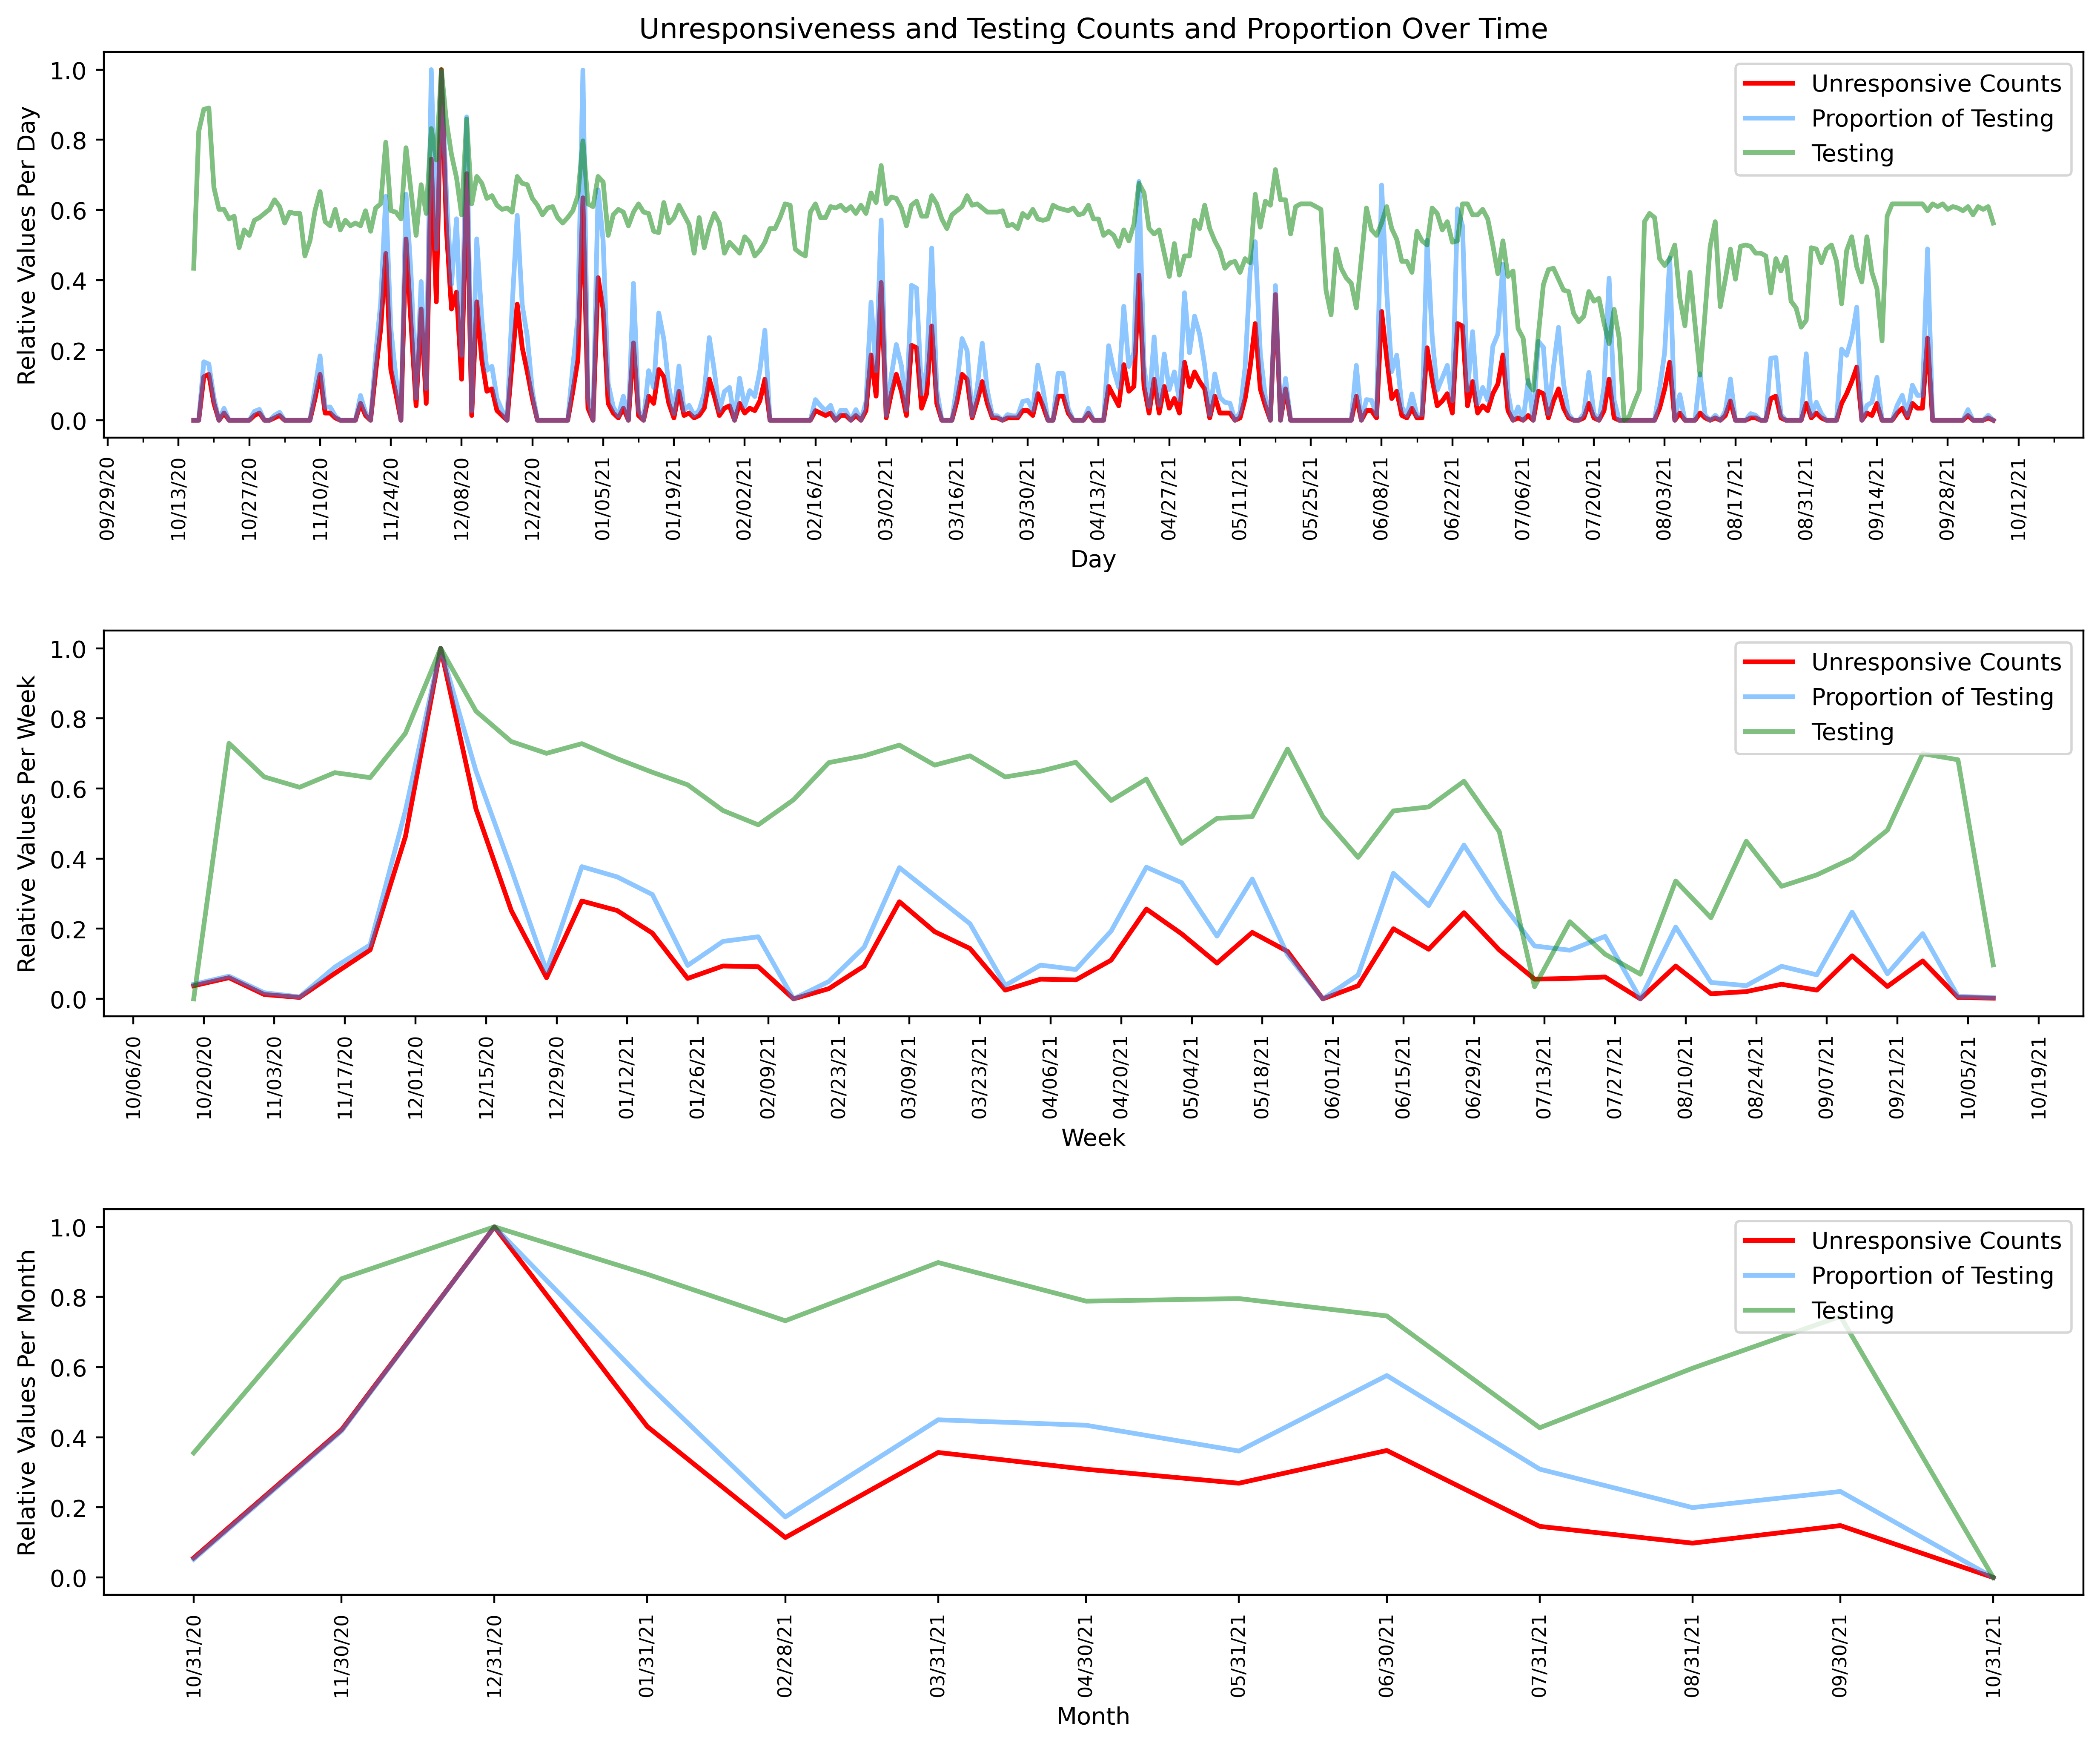

In [6]:
# Plot line graphs of unresponsive counts over time.
# Possibly reduce xtick number.
facecolor = 'white'
fig = plt.figure(figsize = (15, 12), 
                 dpi = 400)
axes = fig.subplots(nrows = 3)
plt.subplots_adjust(hspace = 0.5)

x_labels = ['Day', 
            'Week', 
            'Month']
y_labels = ['Relative Values Per Day', 
            'Relative Values Per Week', 
            'Relative Values Per Month']

for index, var in enumerate(list_of_dfs):
    y1 = var['UNRESPONSIVEMINMAX']
    y2 = var['UNRESPONSIVEPROPORTIONMINMAX']
    y3 = var['TESTINGMINMAX']
    x = var.index
    axes[index].plot(x, y1, linewidth = 2, color = 'red')
    axes[index].plot(x, y2, linewidth = 2, color = 'dodgerblue', alpha = 0.5)
    axes[index].plot(x, y3, linewidth = 2, color = 'green', alpha = 0.5)
    axes[index].set_xlabel(x_labels[index])
    axes[index].set_ylabel(y_labels[index])
    axes[index].xaxis.set_major_formatter(mdates.DateFormatter('%D'))
    axes[index].legend(['Unresponsive Counts',
                        'Proportion of Testing', 
                        'Testing'], 
                       loc='upper right', 
                       bbox_to_anchor=(1, 1))
    plt.setp(axes[index].get_xticklabels(), 
             rotation = 90, 
             fontsize = 8)
    axes[index].set_ylim(-0.05,1.05)

axes[0].xaxis.set_major_locator(mdates.WeekdayLocator(interval = 2))
axes[0].xaxis.set_minor_locator(mdates.WeekdayLocator(interval = 1))
axes[1].xaxis.set_major_locator(mdates.WeekdayLocator(interval = 2))
axes[2].set_xticks(responsiveness_by_month.index)

axes[0].set_title('Unresponsiveness and Testing Counts and Proportion Over Time');

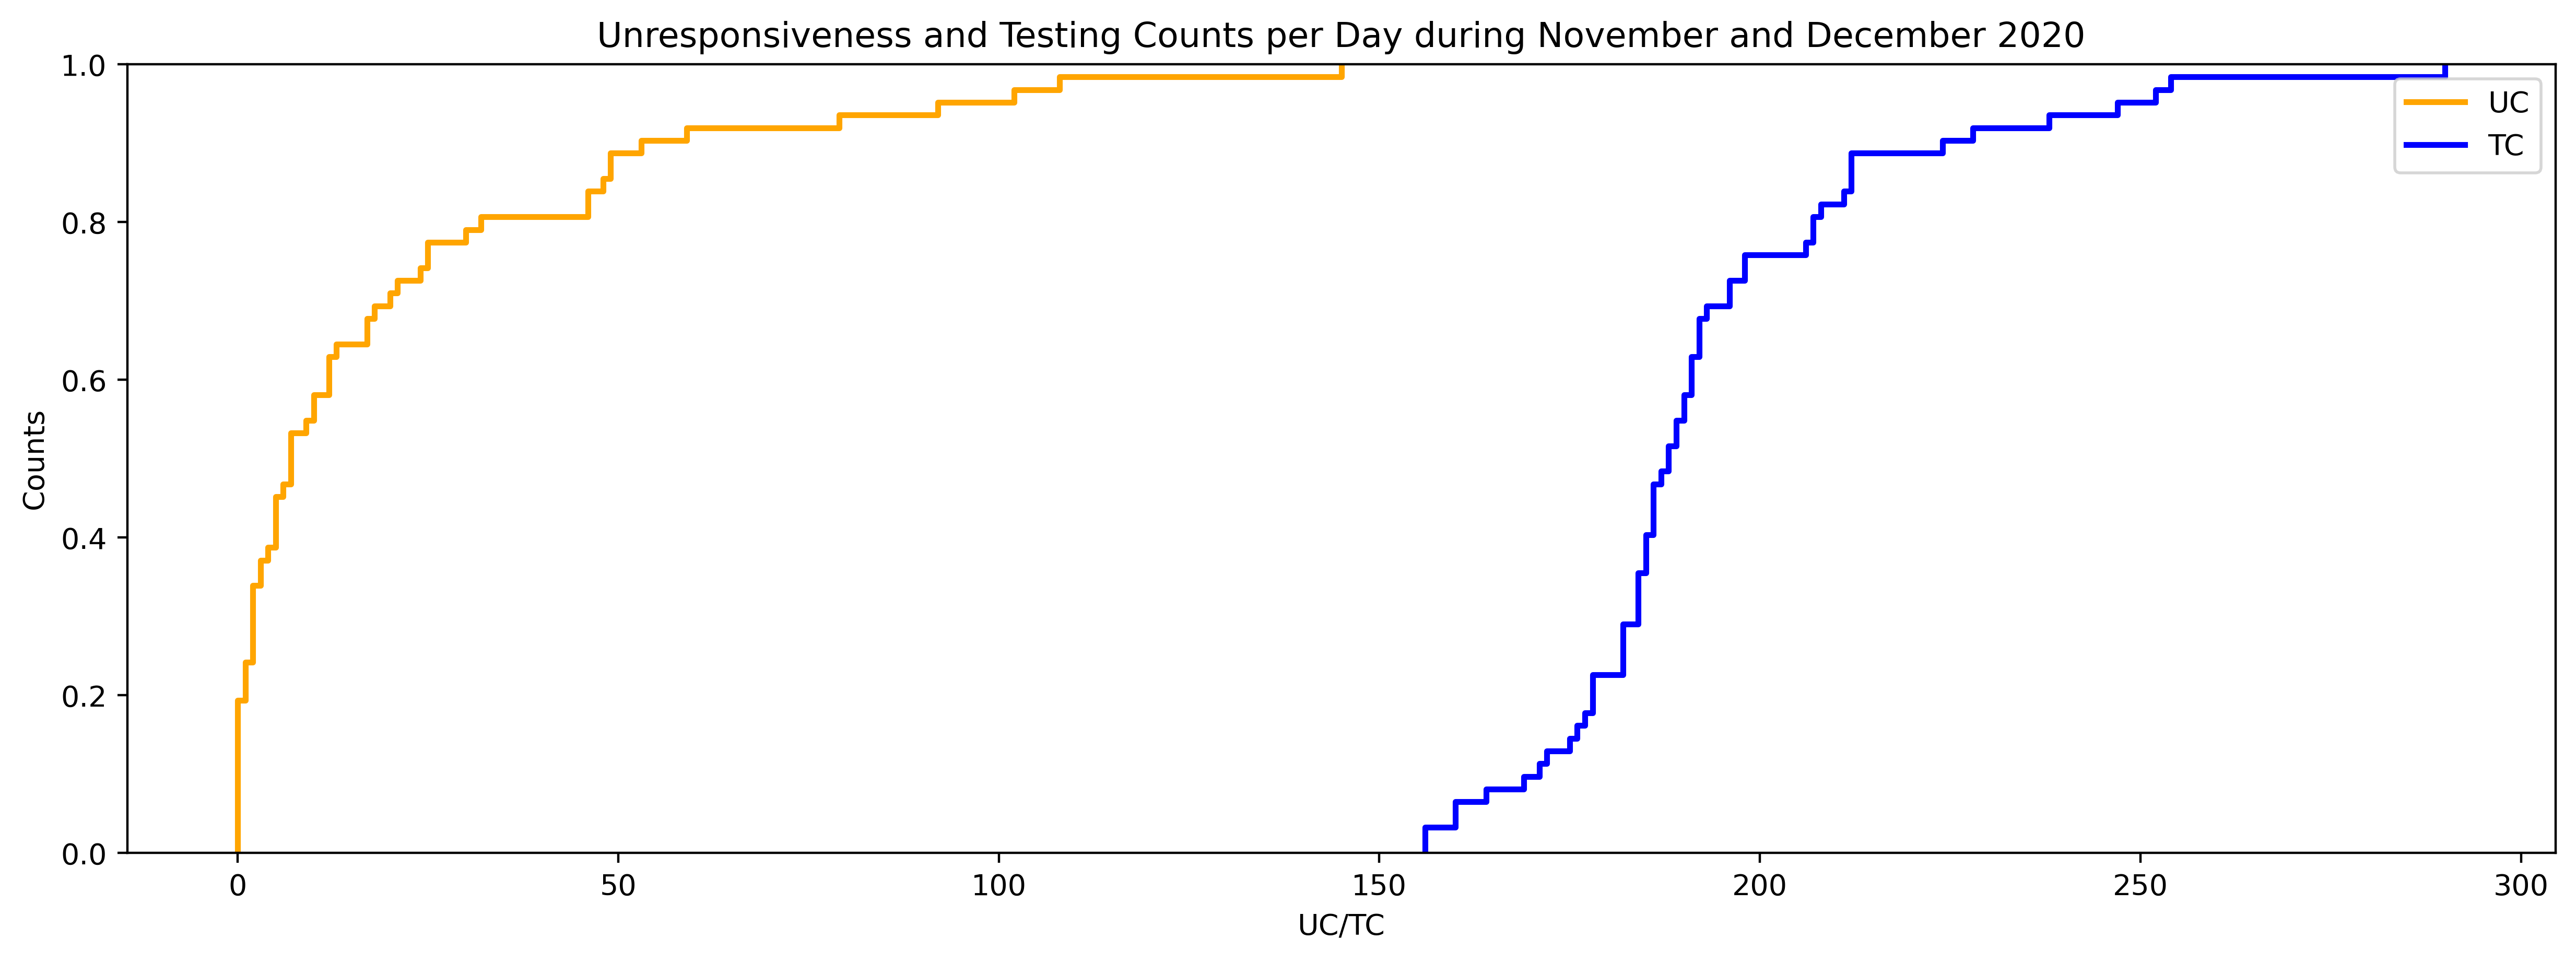

In [7]:
# Plot ecdfs of the unresponsive counts per day for November through December 2020.
facecolor = 'white'
fig = plt.figure(figsize = (15, 5), 
                 dpi = 400)

criteria = (
    (responsiveness_by_day.index >= '2020-12-01') &\
    (responsiveness_by_day.index <= '2021-1-31')
)

colors = ['orange', 
          'blue',
          'red']

for num, i in enumerate(['UNRESPONSIVE', 'TESTING']):
    x = responsiveness_by_day[i][criteria]
    sns.ecdfplot(x, color = colors[num], linewidth = 2)
    
plt.legend(['UC','TC'])
plt.xlabel('UC/TC')
plt.ylabel('Counts')
plt.title('Unresponsiveness and Testing Counts per Day during November and December 2020');

In [8]:
# Create a dataframe that shows consecutive unresponsive signals over twenty second increments and sums them.
for index, value in enumerate(relevant_columns):
    df = (
        all_dfs.groupby(pd.Grouper(freq = '20S'))[value].\
        sum().\
        reset_index().\
        rename(columns = {'sum':f'{value}'}))
    if index == 0:
        concat_dfs_2 = df
    else:
        concat_dfs_2 = concat_dfs_2.merge(df, on = 'DATETIME')

# Possibly refactor.
begin = []
end = []
sum_runs = []
i = 0
for num, row in enumerate(concat_dfs_2.itertuples()):
    if num in range(0, len(concat_dfs_2) - 1):
        upper_value = concat_dfs_2.iloc[num - 1, 2]
        lower_value = concat_dfs_2.iloc[num + 1, 2]
        if 0 not in [row[3], lower_value] and upper_value == 0:
            begin.append(row[1])
            sum_runs.append(0)
            i = sum_runs.index(0)
            sum_runs[i] = row[3]
        elif 0 not in [row[3], upper_value, lower_value]:
            sum_runs[i] += row[3]
        elif 0 not in [row[3], upper_value] and lower_value == 0:
            sum_runs[i] += row[3]
            end.append(concat_dfs_2.iloc[num + 1, 0])

In [9]:
# Show intervals dataframe.
consecutive = pd.DataFrame({'BEGIN': begin, 
                            'END':end, 
                            'UNRESPONSIVE':sum_runs})

consecutive['INTERVAL'] = consecutive['END'] - consecutive['BEGIN']
consecutive['INTERVAL'] = [x.seconds/60 for x in consecutive['INTERVAL']]
consecutive['INTERVAL'] = consecutive['INTERVAL'].astype('int64')

# Possibly extend initial background color to begin and end columns.
cm = sns.color_palette('Blues', as_cmap = True)

def hightlight_timestamp(row):
    """Function to highlight timestamps where unresponsive counts or intervals thereof are outliers."""
    row_highlights = ["" for _ in row.index]
    if (row['INTERVAL'] > 6) or (row['UNRESPONSIVE'] >= 6):
        row_highlights[row.index.get_loc("BEGIN")] = "background-color: orange; font-weight: bold;"
        row_highlights[row.index.get_loc("END")] = "background-color: orange; font-weight: bold;"
    return row_highlights

# Present style DataFrame of outlier data.
consecutive.loc[consecutive['UNRESPONSIVE'] > 1].style.\
apply(hightlight_timestamp, axis=1).\
background_gradient(cmap = cm).\
set_table_styles([
    {'selector': 'th.col_heading', 
     'props': 'text-align: center; background-color: #00008B; color: white;'}], 
    overwrite = False)

,BEGIN,END,UNRESPONSIVE,INTERVAL
0,2020-10-18 06:53:40,2020-10-18 06:54:20,2,0
1,2020-10-18 07:47:20,2020-10-18 07:48:00,3,0
2,2020-10-18 09:40:00,2020-10-18 09:40:40,2,0
3,2020-10-18 23:45:40,2020-10-18 23:46:20,2,0
4,2020-10-19 00:23:20,2020-10-19 00:24:00,2,0
5,2020-10-19 01:01:00,2020-10-19 01:01:40,2,0
6,2020-10-19 01:23:20,2020-10-19 01:24:00,2,0
7,2020-10-19 02:06:40,2020-10-19 02:07:20,2,0
8,2020-10-20 00:08:40,2020-10-20 00:09:20,2,0
9,2020-10-20 00:15:00,2020-10-20 00:15:40,2,0


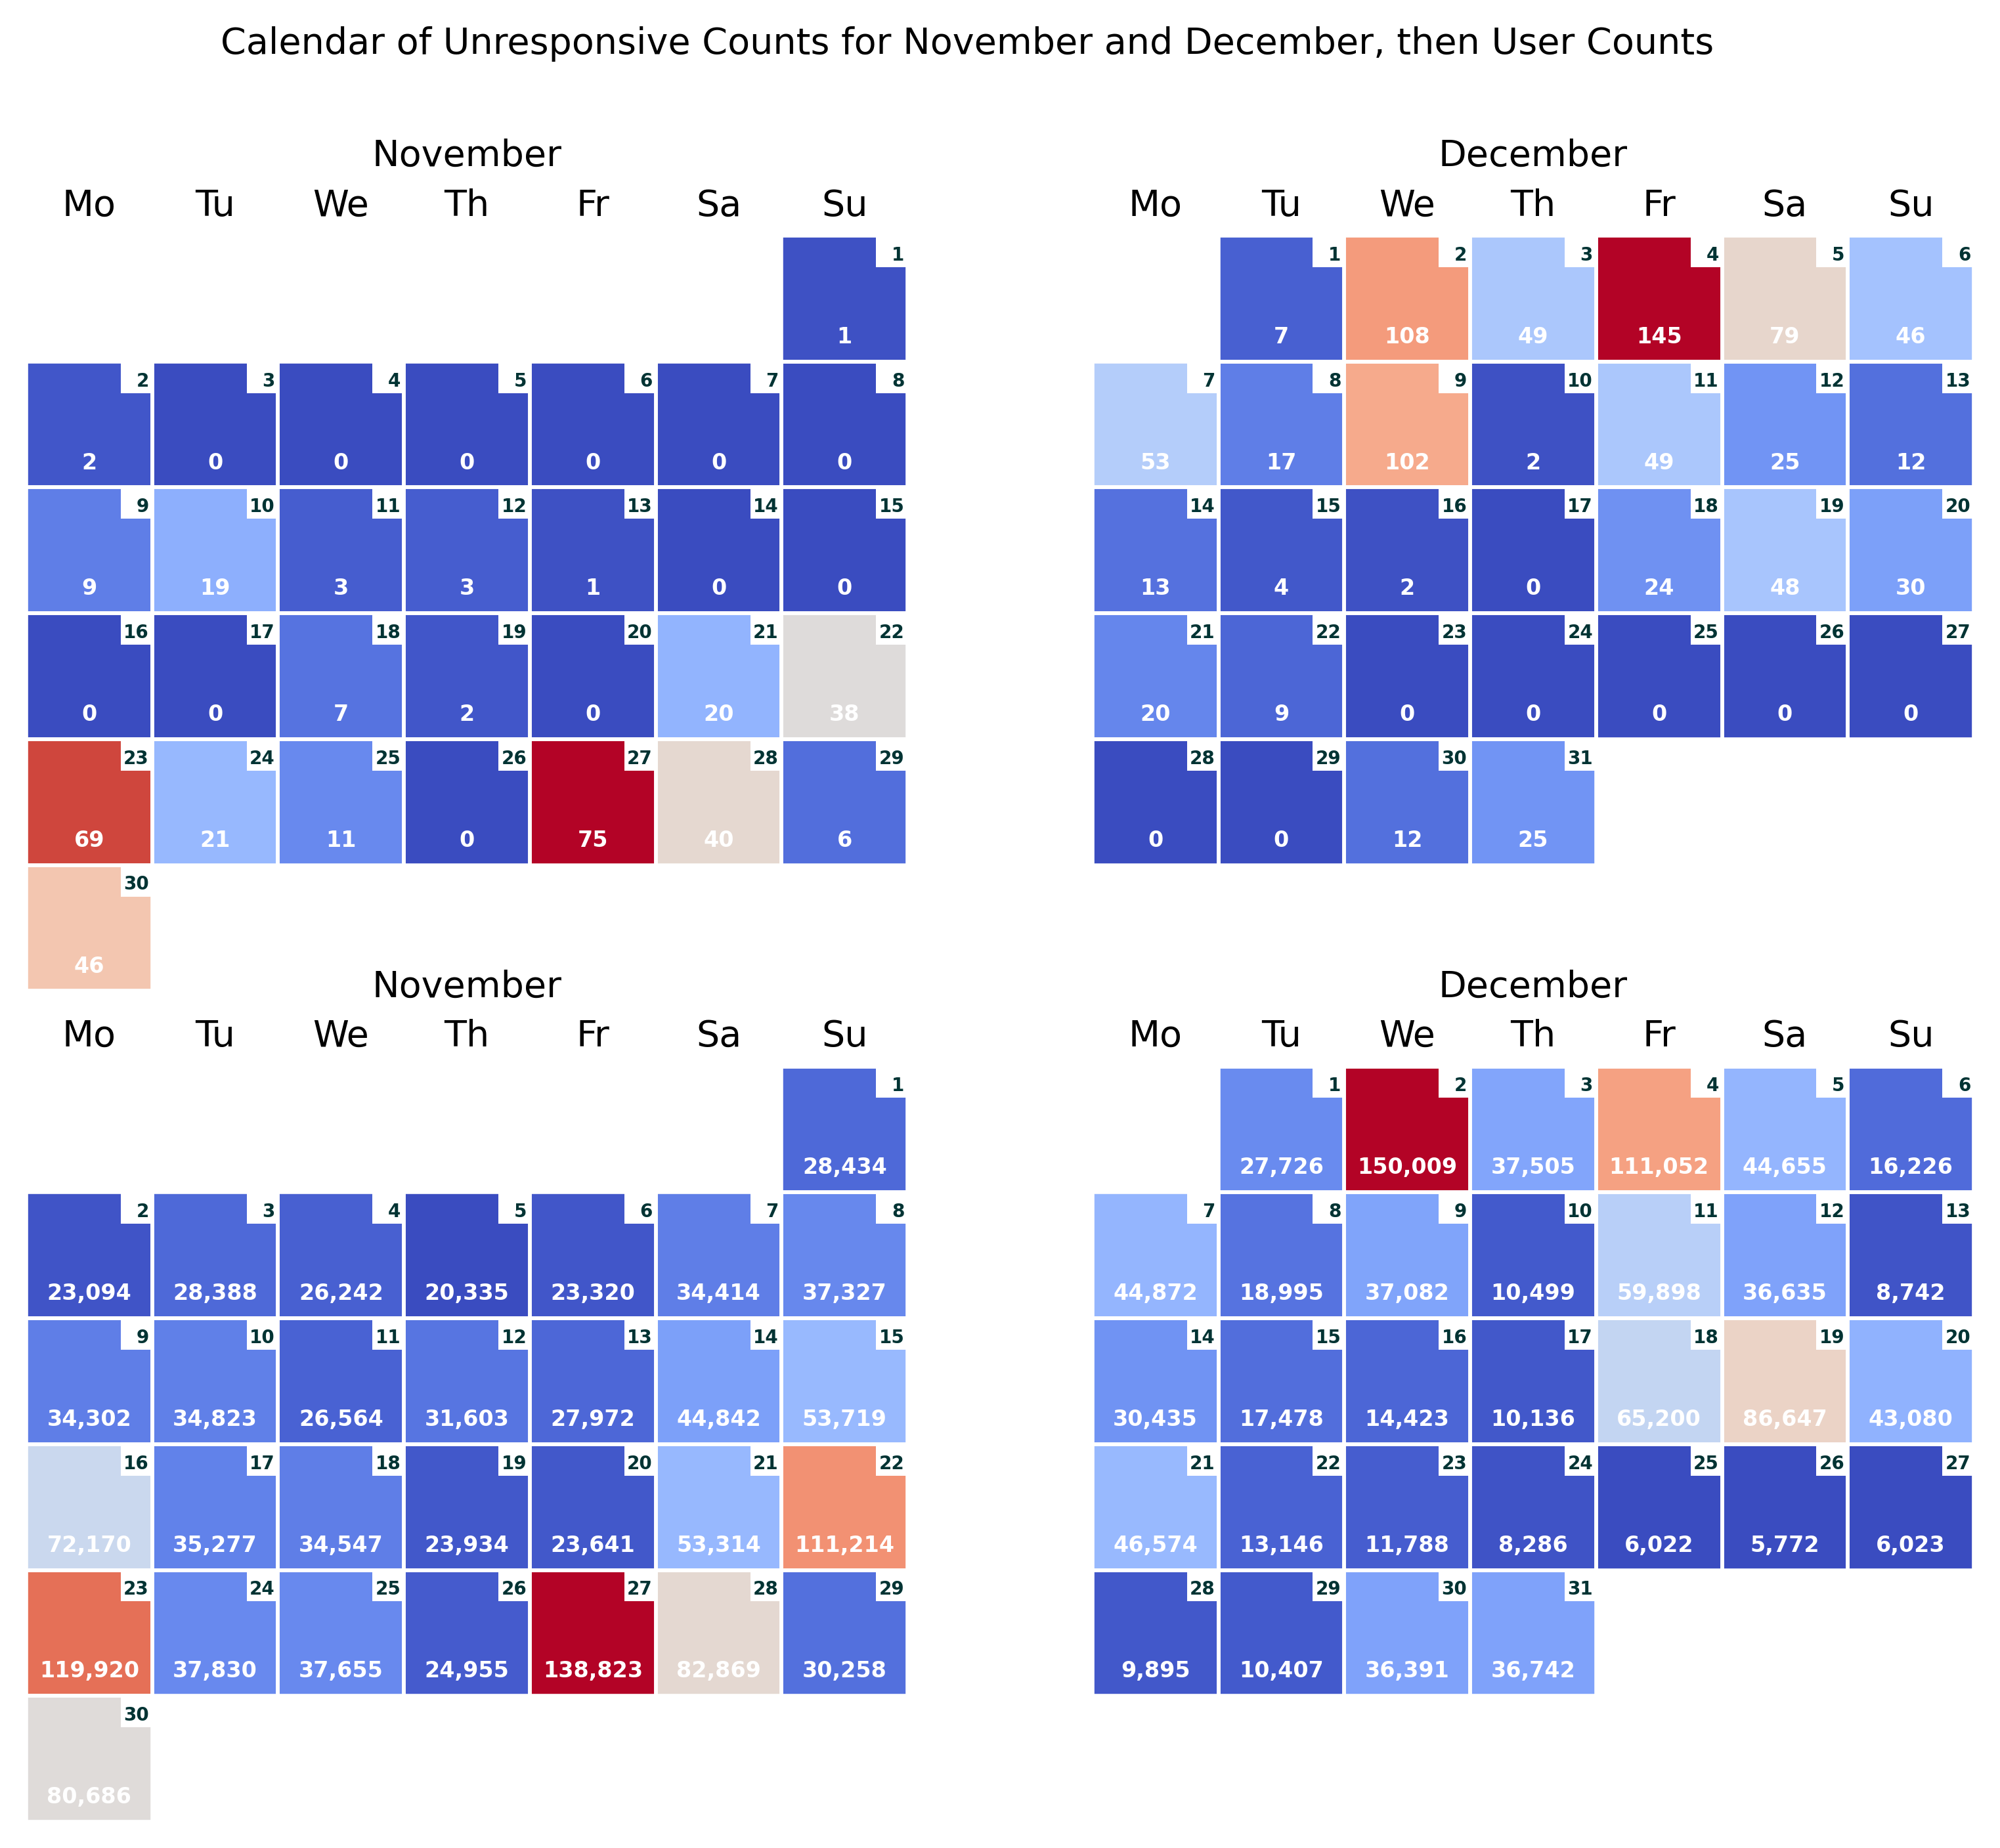

In [10]:
# Calendar heatmap based on modified version of https://stackoverflow.com/a/61277350.
# Check that days are correct.
weeks = [1, 2, 3, 4, 5, 6]
days = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
month_names = ['November', 'December']

def split_months(df, indices_of_desired_values):
    """Split dataframe into months of desired values."""
    
    # Initialize empty 6 x 7 matrix 
    a = np.empty((6, 7))
    a[:] = np.nan

    # Create dictionary where key is month and values are days within a month.
    day_nums = {m:np.copy(a) for m in range(11,13)} 
    
    # Create dictionary where key is month and values are the desired values for that day during a month.
    list_of_day_vals = []
    for i in range(len(indices_of_desired_values)):
        day_vals = {m:np.copy(a) for m in range(11,13)}
        list_of_day_vals.append(day_vals)
        
    
    # Iterate through the DataFrame and assign applicable day to day number.
    # Then assign applicable day value to that day.
    for row in df.itertuples():

        day = row[0].day
        month = row[0].month
        calendar_column = row[0].dayofweek

        if row[0].is_month_start:
            calendar_row = 0
            
        day_nums[month][calendar_row, calendar_column] = day
        
        for index in range(len(indices_of_desired_values)):
            list_of_day_vals[index][month][calendar_row, calendar_column] = row[indices_of_desired_values[index]]

        if calendar_column == 6:
            calendar_row += 1

    return day_nums, list_of_day_vals


def create_calendar_heatmap(day_nums, day_vals):
    """Create actual calendar"""
    fig, ax = plt.subplots(2, 2, figsize = (10, 8), dpi = 400)
    plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
    
    j = [0,0,1,1]
    k = [0,1,0,1]

    for i, axs in enumerate(ax.flat):
        # Cycle through unresponsive counts for Nov. and Dec. 2020, then user counts, creating calendar for each.
        index = j[i]
        second_index = k[i]

        axs.imshow(day_vals[index][second_index+11], cmap = 'coolwarm')
        axs.set_title(month_names[second_index], fontsize = 10)

        axs.set_xticks(np.arange(len(days)))
        axs.set_xticklabels(days, fontsize = 10, color = 'black')
        
        axs.set_yticklabels([])

        axs.tick_params(axis = 'both',
                        which = 'both',
                        length = 0)
        axs.xaxis.tick_top()
        
        # Despine the whole plot.
        for edge in ['left', 'right', 'bottom', 'top']:
            axs.spines[edge].set_color('white')

        for w in range(len(weeks)):
            for d in range(len(days)):
                
                day_val = day_vals[index][second_index+11][w, d]
                day_num = day_nums[second_index+11][w, d]
                
                # If value isn't na add day number and day value text.
                if not np.isnan(day_num):
                    axs.text(d, w+0.3, 
                             f"{day_val:,.0f}",
                             ha = "center", 
                             va = "center",
                             fontsize = 6, 
                             color = "w", 
                             fontweight = 'bold',
                             alpha = 1)
                    
                    axs.text(d+0.475, 
                             w-0.35, 
                             f"{day_num:0.0f}",
                             ha = "right", 
                             va = "center",
                             fontsize = 5, 
                             color = "#003333",
                             fontweight = 'bold',
                             alpha = 1)
                    
                    # Draw white grid lines around boxes.
                    patch_coords = ((d - 0.5, w + 0.5),
                                    (d + 0.5, w + 0.5),
                                    (d + 0.5, w - 0.5),
                                    (d - 0.5, w - 0.5))
                    
                    square = Polygon(patch_coords, fc = 'none', edgecolor = 'w')
                    axs.add_artist(square)
                    
                    # Draw smaller white boxes for day numbers.
                    patch_coords = ((d + 0.25, w - 0.5),
                                    (d + 0.5, w - 0.5),
                                    (d + 0.5, w - 0.25),
                                    (d + 0.25, w - 0.25))
                    
                    square = Polygon(patch_coords, fc = 'w')
                    axs.add_artist(square)

    plt.suptitle('Calendar of Unresponsive Counts for November and December, then User Counts', 
                 fontsize = 10)

# Call functions and plot.
day_nums, day_vals = split_months(responsiveness_by_day[16:77], [1,4])
create_calendar_heatmap(day_nums, day_vals)

In [11]:
# Try to limit models to days where system was actually being used.
scatter_responsiveness_by_day = responsiveness_by_day.loc[responsiveness_by_day['USERCOUNT'] > 10]

# Create Poisson base model to predict unresponsive counts per 10,000 user commands per day.
base_exog = sm.add_constant(scatter_responsiveness_by_day[[]])
offset = np.log(scatter_responsiveness_by_day['USERCOUNT']/10000)

base_model = sm.GLM(endog = scatter_responsiveness_by_day['UNRESPONSIVE'],
                    exog = base_exog,
                    family = sm.families.Poisson(),
                    offset = offset).fit()

# Obtain mean for unresponsive counts.
base_poisson_mu = np.exp(base_model.params['const'])

base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           UNRESPONSIVE   No. Observations:                  357
Model:                            GLM   Df Residuals:                      356
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2624.3
Date:                Sun, 07 Nov 2021   Deviance:                       4353.4
Time:                        14:05:23   Pearson chi2:                 1.15e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2725      0.017     73.058      0.000       1.238       1.307
==============================================================================
"""

The chances having 5 or more unresponsive counts per 10,000 user commands in a day is 15%.


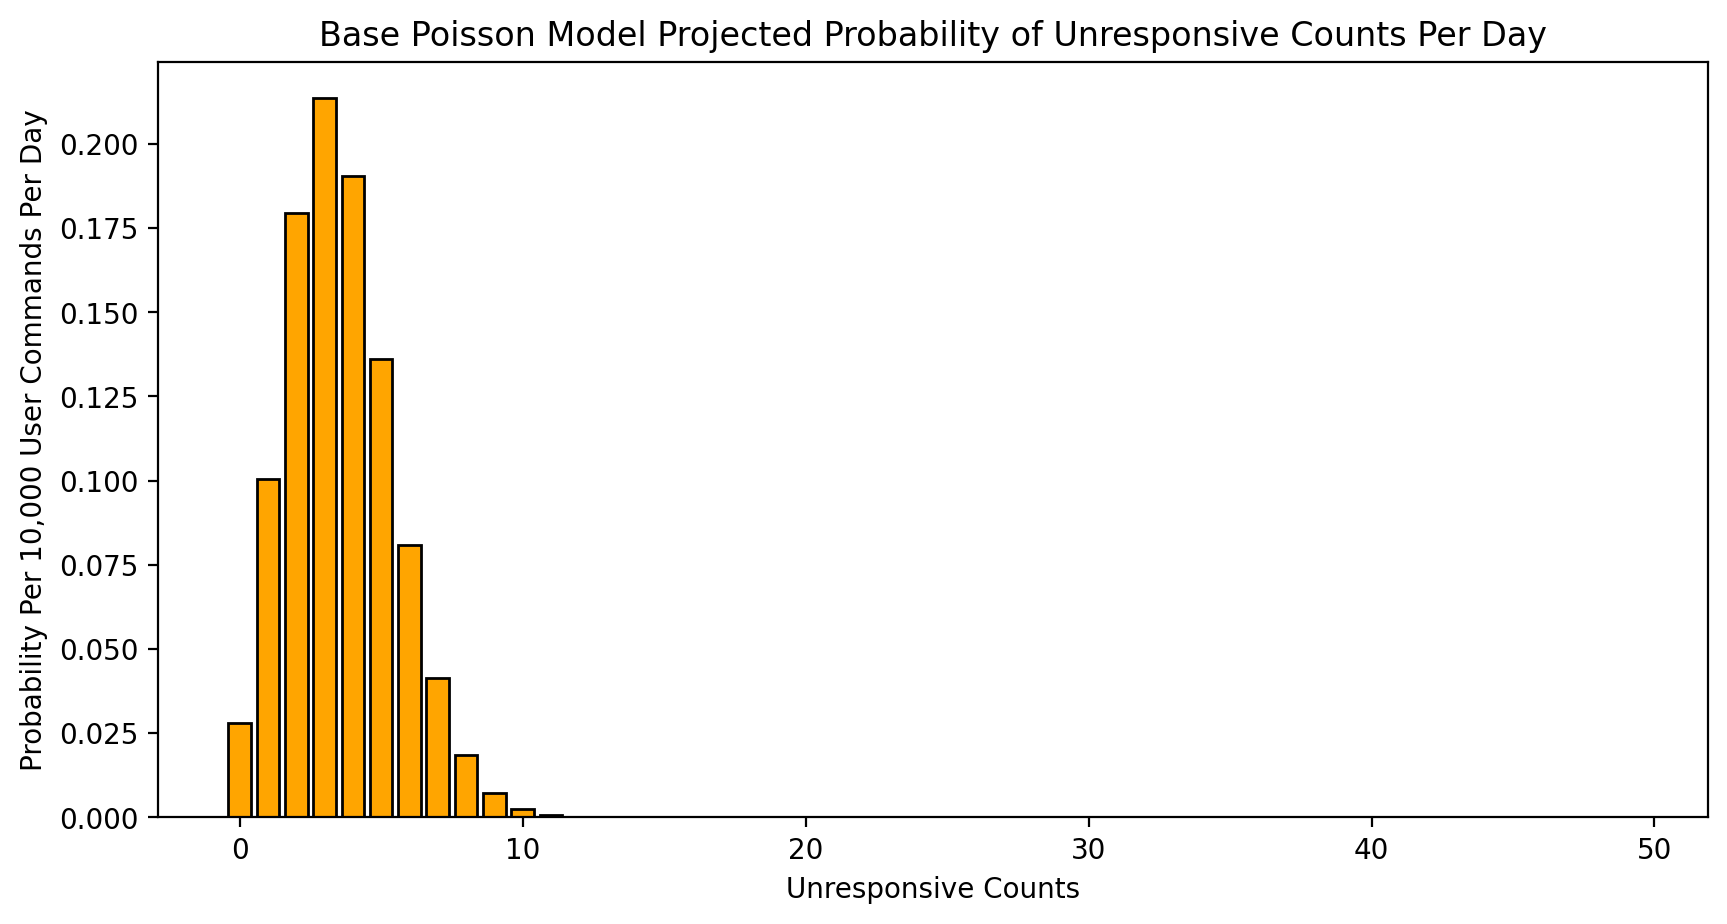

In [12]:
# Create appropriate x range and plot probabilities of unresponsive counts per 10,000 users...
# Using base poisson model.

x = np.arange(start = 0, stop = 50, step = 1)
y = poisson.pmf(x, base_poisson_mu)

plt.figure(figsize = (10,5), dpi = 200)
plt.bar(x, y, color = 'orange', edgecolor = 'k')
plt.title('Base Poisson Model Projected Probability of Unresponsive Counts Per Day')
plt.xlabel('Unresponsive Counts')
plt.ylabel('Probability Per 10,000 User Commands Per Day');

print(f'The chances having 5 or more unresponsive counts per 10,000 user commands \
in a day is {1 - poisson.cdf(5, base_poisson_mu):.0%}.')

In [13]:
# Create negative binomial base model for predicted of unresponsive counts per 10,000 user commands.
alpha = 1
nb_base_model = sm.GLM(endog = scatter_responsiveness_by_day['UNRESPONSIVE'],
                       exog = base_exog,
                       family = sm.families.NegativeBinomial(alpha = 1),
                       offset = offset).fit()

# Obtain mean for unresponsive counts.
nb_base_mu = np.exp(nb_base_model.params['const'])

# Obtain variance as in NB model, mean and variance are different.
nb_base_sigma = np.sqrt(nb_base_mu + alpha*nb_base_mu**2)

nb_base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           UNRESPONSIVE   No. Observations:                  357
Model:                            GLM   Df Residuals:                      356
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1099.0
Date:                Sun, 07 Nov 2021   Deviance:                       766.96
Time:                        14:05:23   Pearson chi2:                 3.85e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2611      0.057     22.011      0.000       1.149       1.373
==============================================================================
"""

The chances having 5 or more unresponsive counts per 10,000 user commands in a day is 22%.


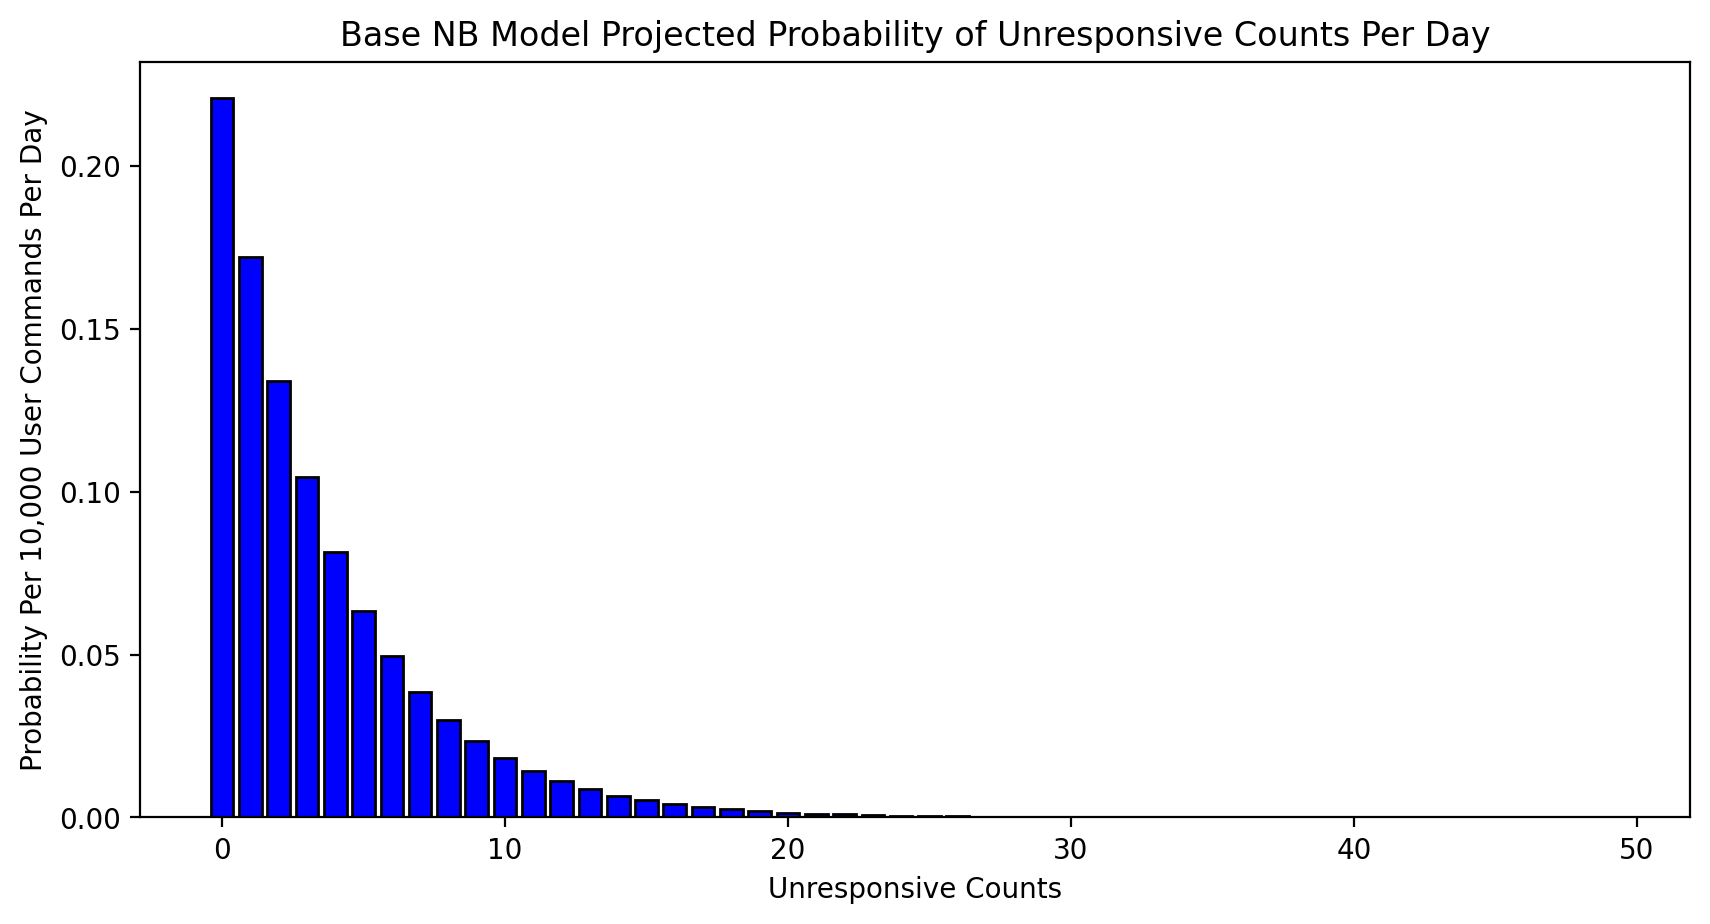

In [14]:
# Using negative binomial base model to predict probabilities of unresponsive counts per day.
nb_base_p = nb_base_mu / nb_base_sigma**2
nb_base_n = nb_base_mu**2 / (nb_base_sigma**2 - nb_base_mu)
x = np.arange(start = 0, stop = 50, step = 1)
y = nbinom.pmf(x, p = nb_base_p, n = nb_base_n)

plt.figure(figsize = (10,5), dpi = 200)
plt.bar(x, y, color = 'blue', edgecolor = 'k')
plt.title('Base NB Model Projected Probability of Unresponsive Counts Per Day')
plt.xlabel('Unresponsive Counts')
plt.ylabel('Probability Per 10,000 User Commands Per Day');

print(f'The chances having 5 or more unresponsive counts per 10,000 user commands \
in a day is {1 - nbinom.cdf(5, p = nb_base_p, n = nb_base_n):.0%}.')

In [15]:
# Poisson model using log of 10,000 additional user commands per day as explanatory variable.
full_model_exog = sm.add_constant(np.log(scatter_responsiveness_by_day['USERCOUNT']))

poisson_model = sm.GLM(endog = scatter_responsiveness_by_day['UNRESPONSIVE'],
                       exog = full_model_exog,
                       family = sm.families.Poisson()).fit()

# Obtain mean for unresponsive counts.
poisson_mu = np.exp(poisson_model.params['const'])

# Negative binomial model using log of 10,000 additional user commands per day as explanatory variable.
alpha = 1
nb_model = sm.GLM(endog = scatter_responsiveness_by_day['UNRESPONSIVE'],
                  exog = full_model_exog,
                  family = sm.families.NegativeBinomial()).fit()

# Obtain mean for unresponsive counts.
nb_mu = np.exp(nb_model.params['const'])

# Obtain variance as in NB model, mean and variance are different.
nb_sigma = np.sqrt(nb_mu + alpha*nb_mu**2)
nb_p = nb_mu / nb_sigma**2
nb_n = nb_mu**2 / (nb_sigma**2 - nb_mu)

print(poisson_model.summary())
print('\n')
print(nb_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                  357
Model:                            GLM   Df Residuals:                      355
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2565.0
Date:                Sun, 07 Nov 2021   Deviance:                       4234.7
Time:                        14:05:24   Pearson chi2:                 1.84e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7315      0.260    -41.331      0.0

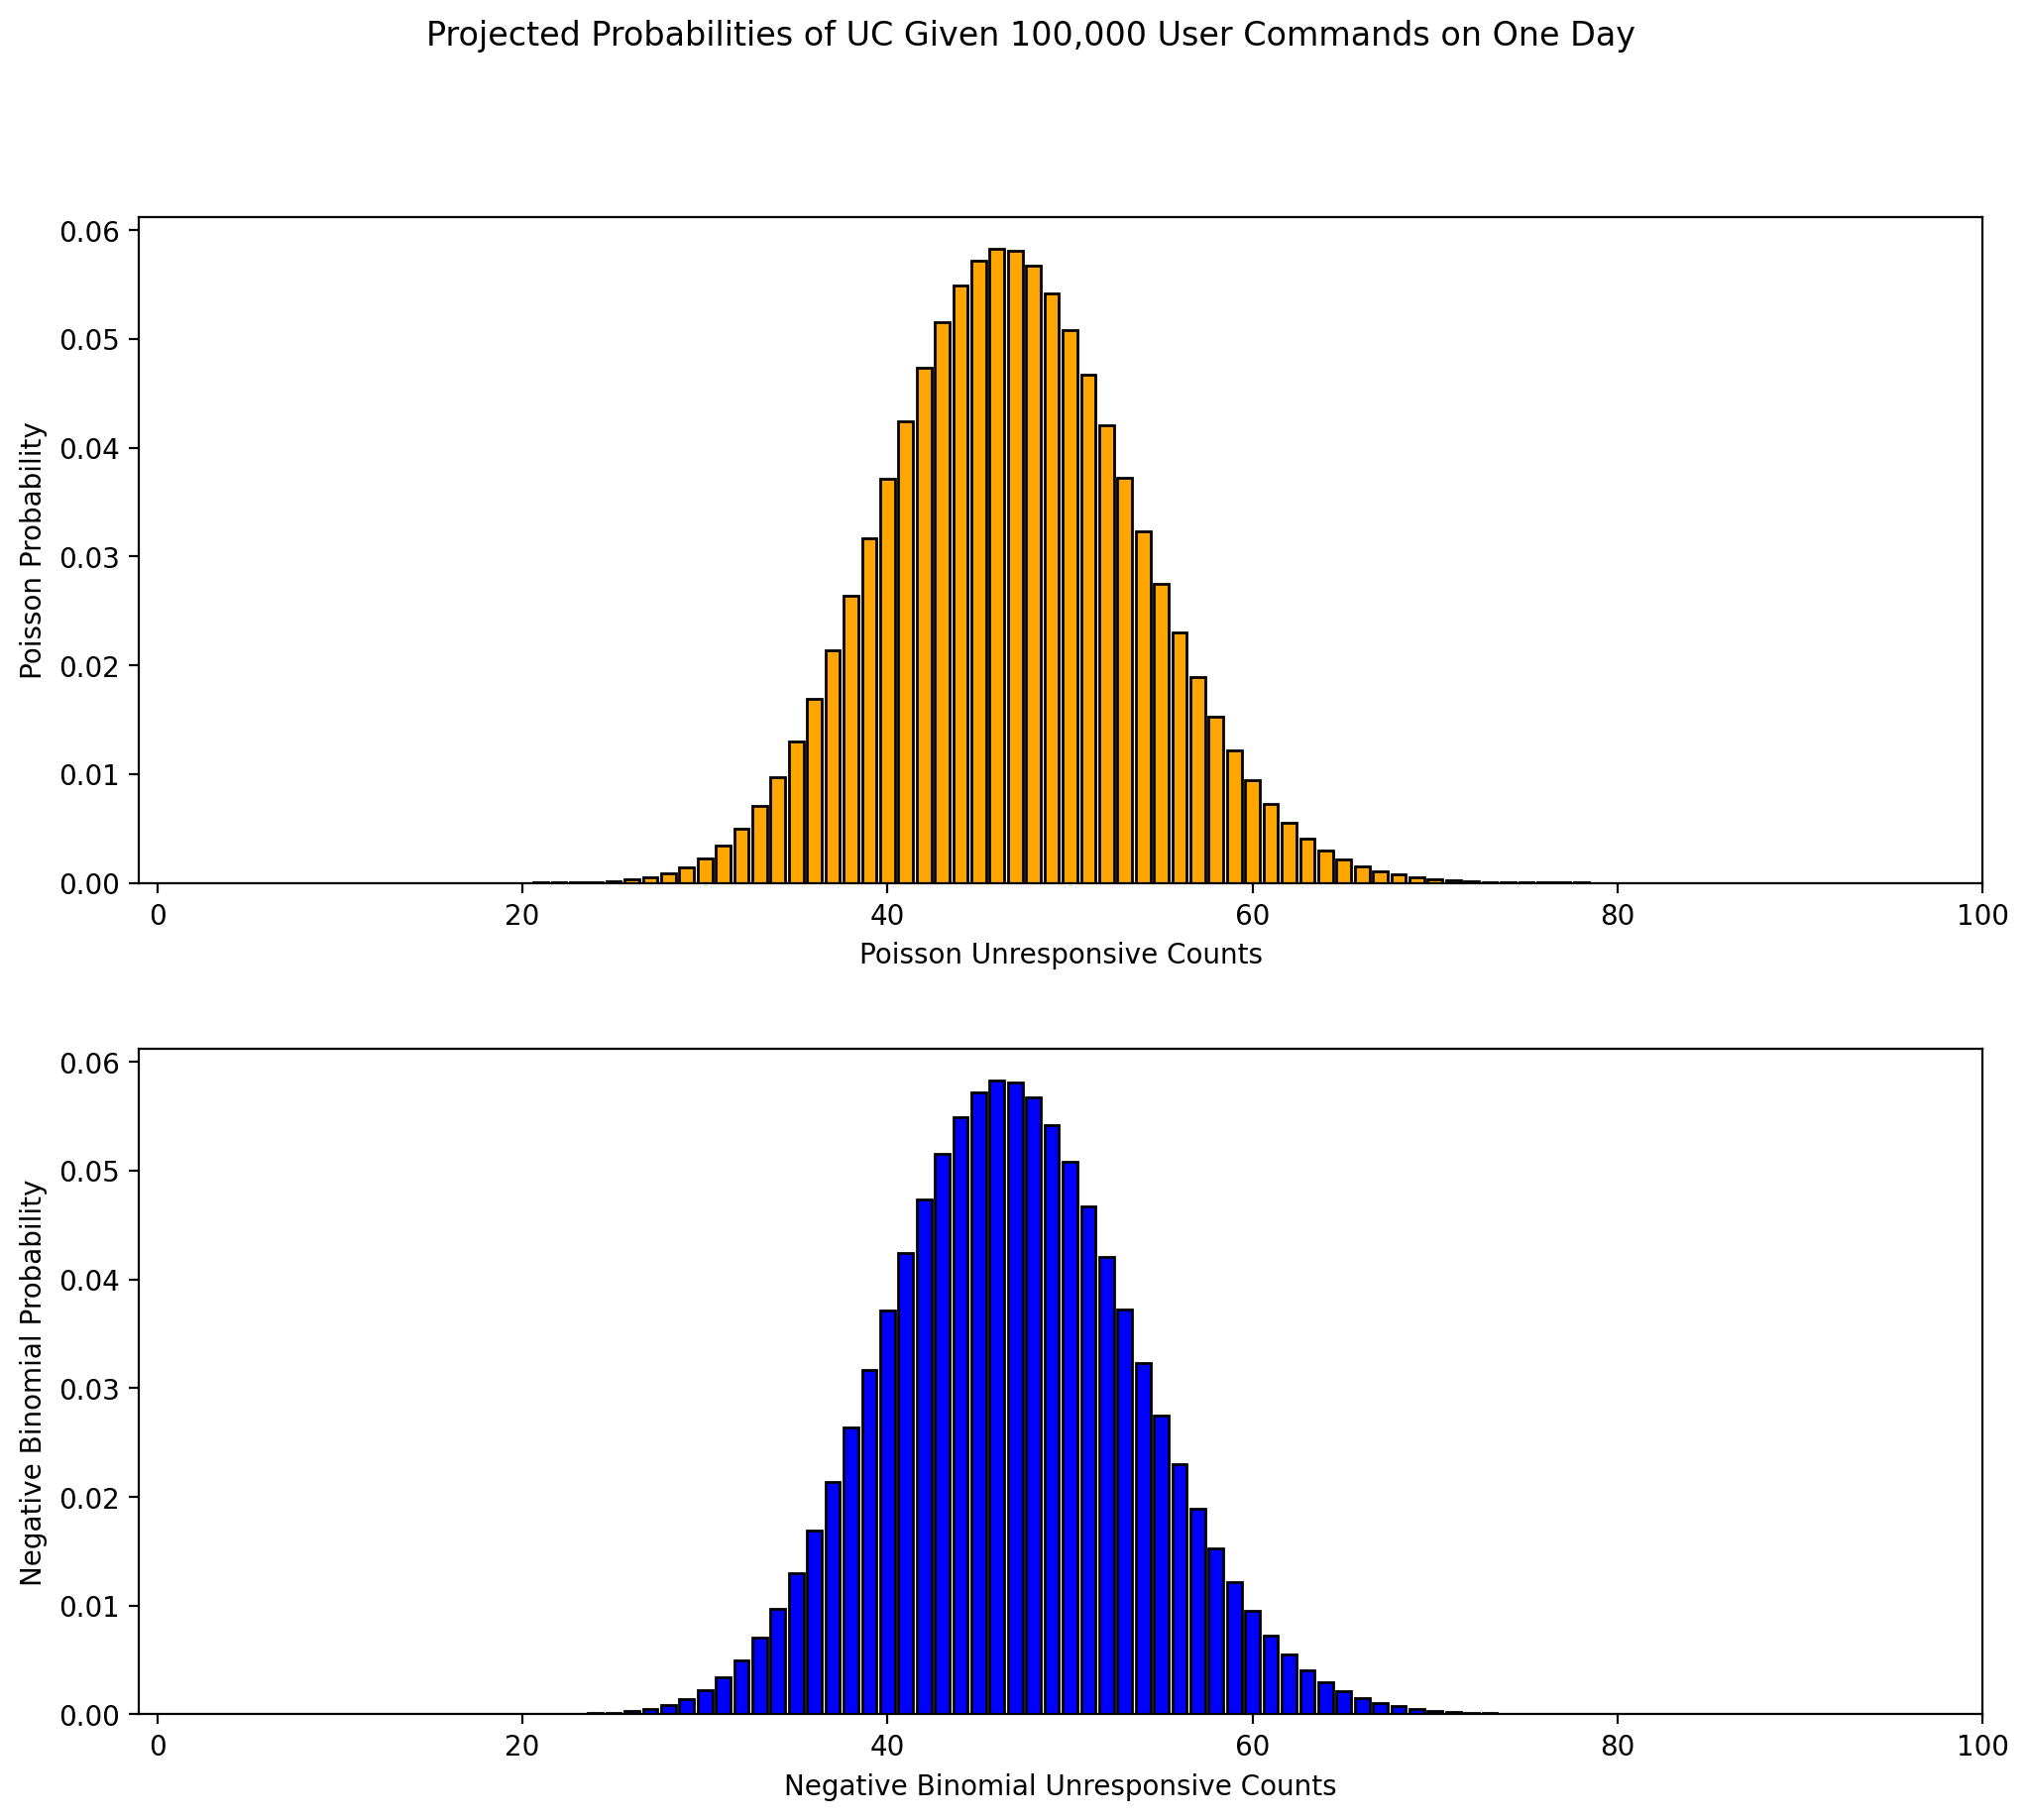

In [16]:
# Sample usercounts per day then predict off that sorted sample using Poisson and NB models.
# Consider running auxiliary NB model.
# Consider creating slider to adjust test amount.
graph_exog = sm.add_constant(np.array([np.log(100000)]), has_constant = 'add')

poisson_predicted_mu = poisson_model.predict(graph_exog)
nb_predicted_mu = nb_model.predict(graph_exog)

x = np.arange(start = 0, stop = 100, step = 1)
y_1 = poisson.pmf(x, poisson_predicted_mu)

nb_p = nb_mu / nb_sigma**2
nb_n = nb_mu**2 / (nb_sigma**2 - nb_mu)
y_2 = nbinom.pmf(x, p = nb_p, n = nb_n)

fig, axes = plt.subplots(2, 1, figsize = (12,10), dpi = 200, sharey = True)
plt.suptitle('Projected Probabilities of UC Given 100,000 User Commands on One Day')
plt.subplots_adjust(hspace = 0.25)
colors = ['orange', 'blue']
for index, ax in enumerate(axes):
    ax.bar(x, y_1, color = colors[index], edgecolor = 'k')
    ax.set_xlim(-1,100)
    
axes[0].set_ylabel('Poisson Probability')
axes[0].set_xlabel('Poisson Unresponsive Counts')
axes[1].set_ylabel('Negative Binomial Probability')
axes[1].set_xlabel('Negative Binomial Unresponsive Counts');

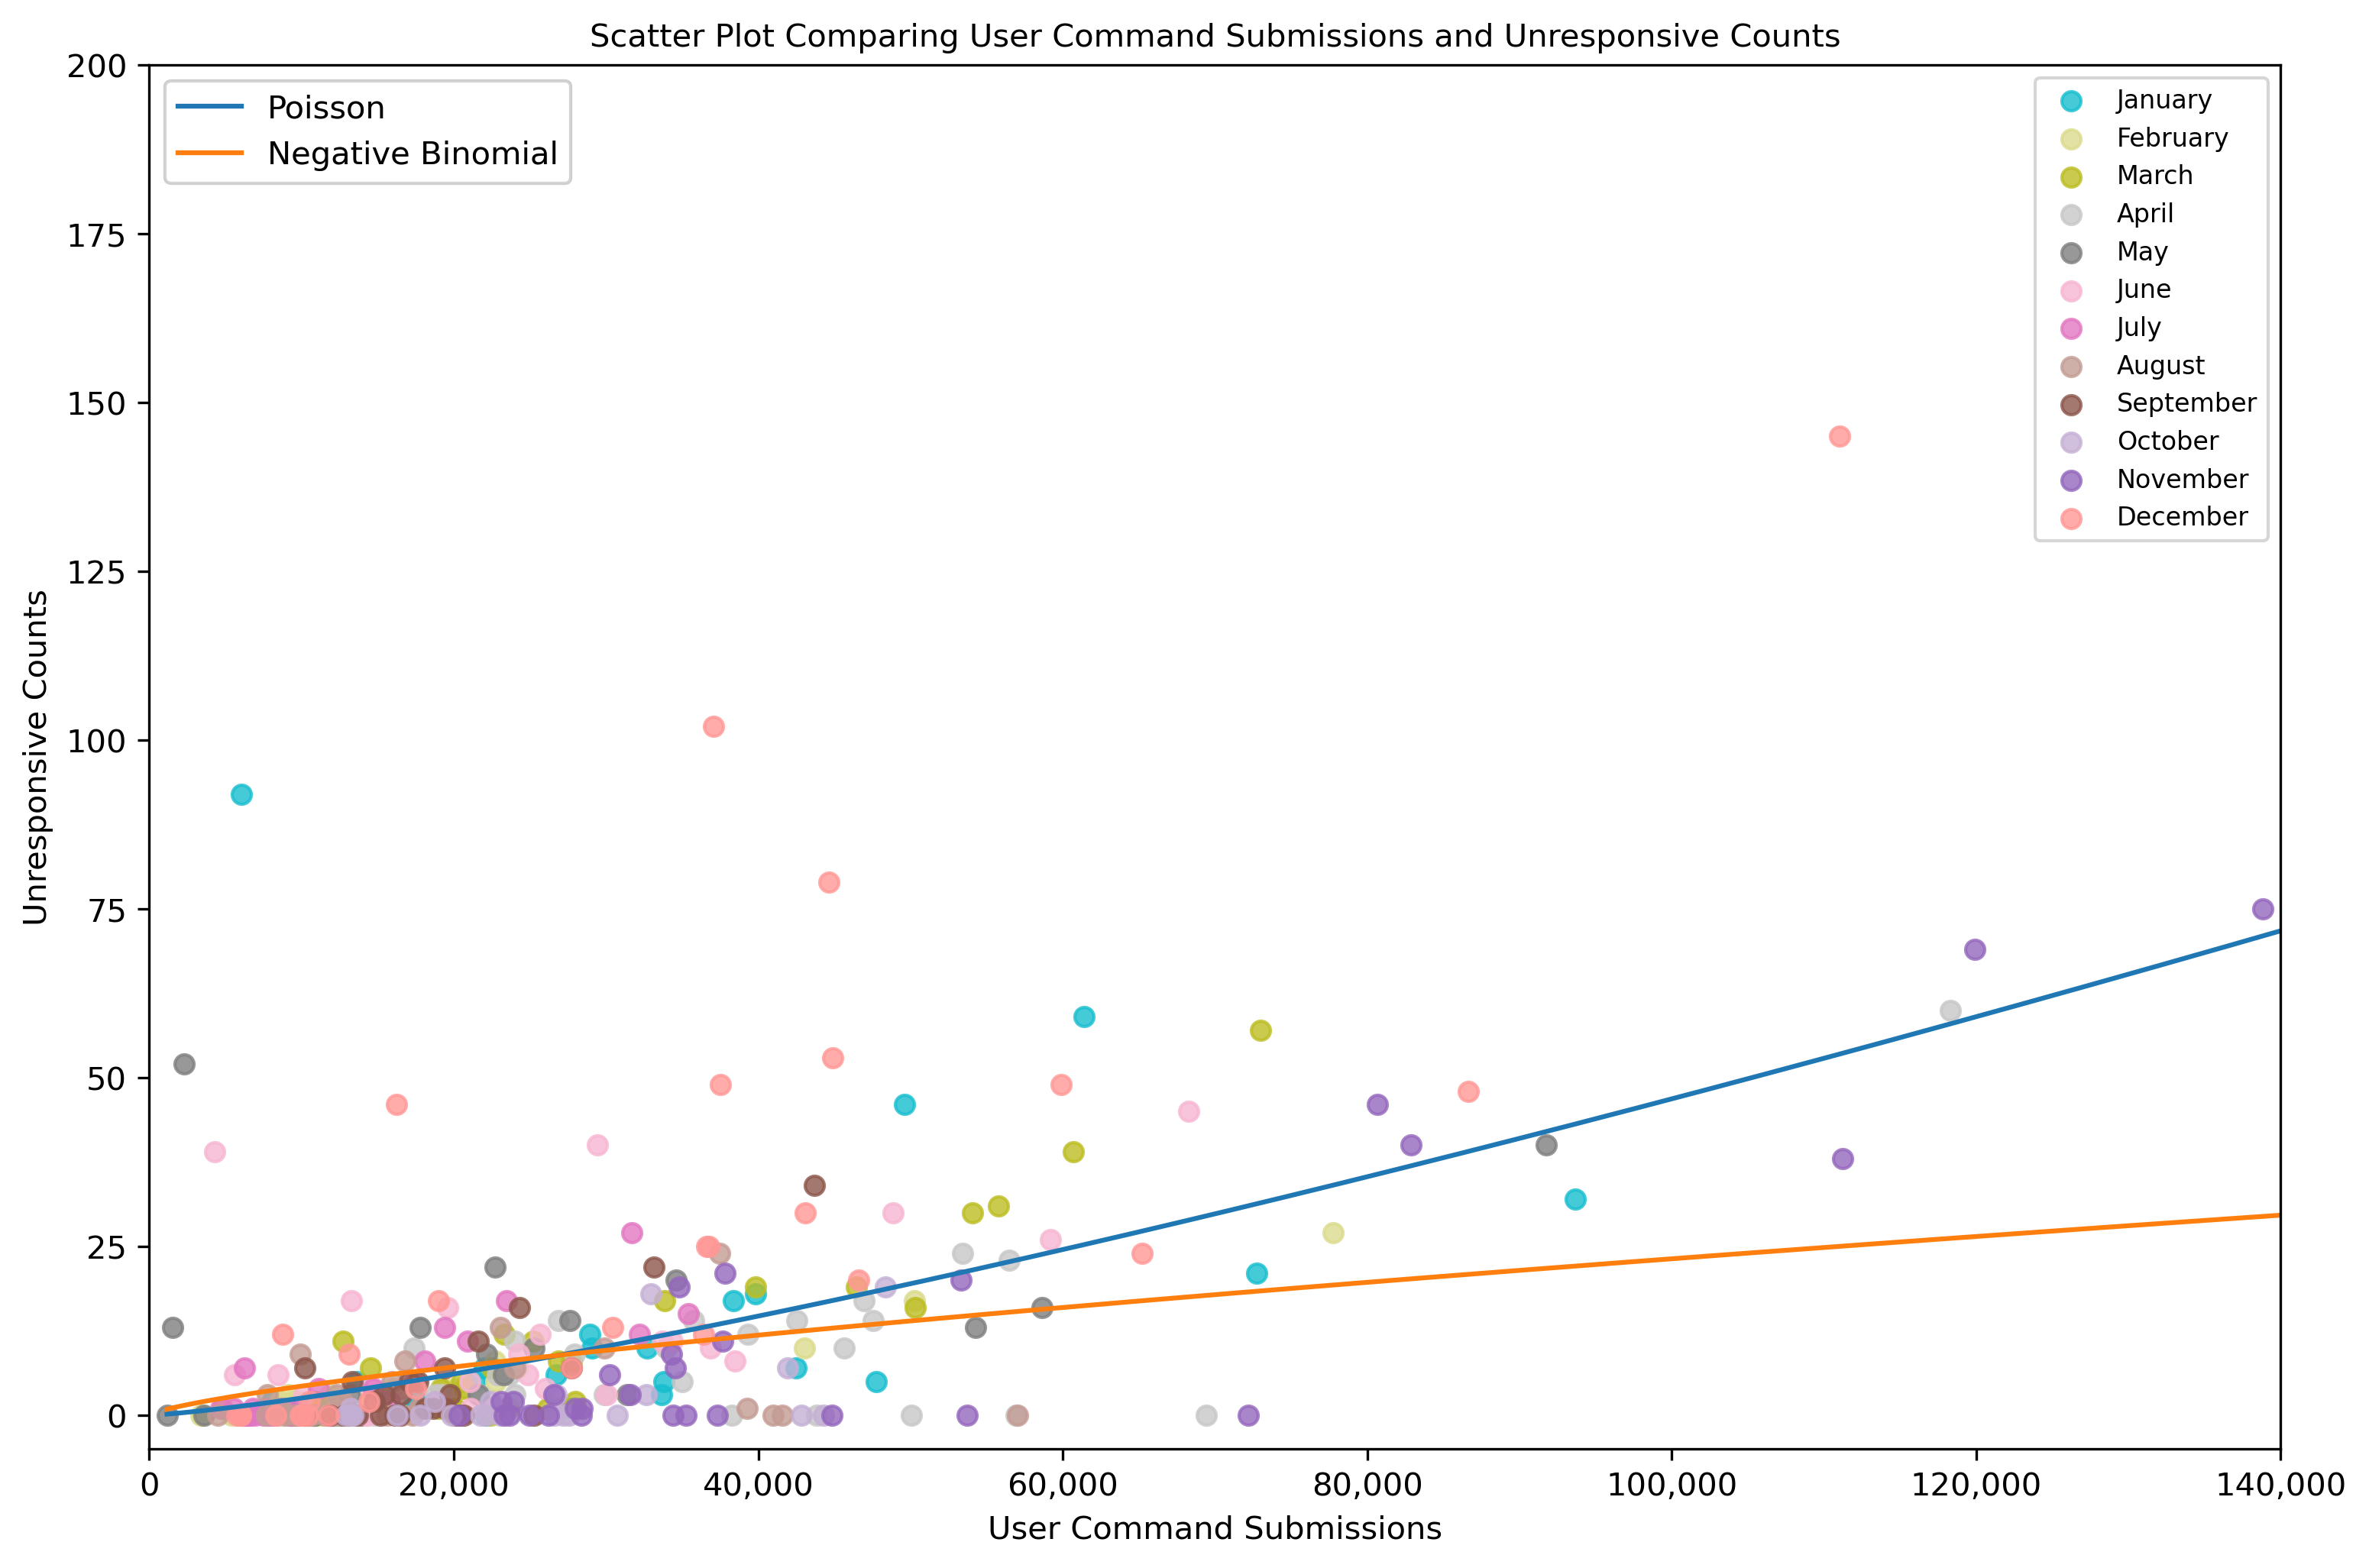

In [18]:
# Plot scatterplot of user commands and unresponsive counts.
# Also plot regression lines on top of scatter plot to see fit visually.

# Set month names for legend.
months = ('January',
          'February',
          'March',
          'April',
          'May',
          'June',
          'July',
          'August',
          'September',
          'October',
          'November',
          'December')

# Set plot fundamentals.
fig, ax = plt.subplots(figsize = (12, 8), dpi = 300)
x = scatter_responsiveness_by_day['USERCOUNT']
y = scatter_responsiveness_by_day['UNRESPONSIVE']
list_of_scatter = []
cmap = matplotlib.cm.get_cmap('tab20_r')

# Loop through months and plot scatterpoints.
for i in range(1,13):
    pl = ax.scatter(x.loc[scatter_responsiveness_by_day.index.month == i],
                    y.loc[scatter_responsiveness_by_day.index.month == i],
                    color = cmap(i),
                    alpha = 0.8)
    list_of_scatter.append(pl)

# Create legend of month names.
first_legend = ax.legend(list_of_scatter,
                         months,
                         scatterpoints = 1,
                         loc = 'upper right',
                         fontsize = 8)
ax.add_artist(first_legend)

# Create x prediction range for models.
x_predict_range = np.linspace(start = scatter_responsiveness_by_day['USERCOUNT'].min(),
                              stop = scatter_responsiveness_by_day['USERCOUNT'].max(), 
                              num = 357) # Shape required.

# Generate y values from model.
y_1 = poisson_model.predict(sm.add_constant(np.log(x_predict_range)))
y_2 = nb_model.predict(sm.add_constant(np.log(x_predict_range)))

# Plot regression lines.
poisson_line, = ax.plot((x_predict_range),y_1)
nb_line, = ax.plot((x_predict_range),y_2)

# Create legend for each line.
poisson_line.set_label('Poisson')
nb_line.set_label('Negative Binomial')
second_legend = ax.legend([poisson_line, nb_line], 
                          ['Poisson','Negative Binomial'], 
                          loc = 'upper left')
ax.add_artist(second_legend)
ax.get_xaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylim(-5, 200)
plt.xlim(-5, 140000)
plt.xlabel('User Command Submissions')
plt.ylabel('Unresponsive Counts')
plt.title('Scatter Plot Comparing User Command Submissions and Unresponsive Counts', fontsize = 10);